In [1061]:
POWER_CONSUMPTIONS = [1., 0.47, 0.105, 0]
WAKE_UP_COSTS = [0, 0.12, 0.33, 1.] # assume all are interesting at some point
#same as Antoniadis et al.

In [1062]:
import numpy as np

# offline otpimum
def OPT(requests):
    res = [0] * len(requests)
    for t, req in enumerate(requests):
        res[t] = 0 if req>=1 else req+1000
    return res

# blindly trust
def FTP(requests, pred):
    res = [0] * len(requests)
    for t, req in enumerate(requests):
        res[t] = 0 if pred[t]>=1 else requests[t]+1000
    return res

## Randomized Algorithms

In [1063]:
import import_ipynb
import Randomized_Ski_Rental


def Kumar_pi(pred, lambd):
    return Randomized_Ski_Rental.kumar_distribution(lambd, 20, 20 * pred)

def PRSR_pi(pred, gamma):
    return Randomized_Ski_Rental.RSR(int(20*pred), gamma, 20, max( int(20 * pred)+1 , 20 ))

import numpy as np

def F_inverse_p(pi):

    F = np.cumsum(pi)                         
    x = np.arange(0.05, 0.05*(len(pi)+1), 0.05)  
    
    p = np.random.rand()                      
    idx = np.searchsorted(F, p)               
    t = x[np.clip(idx, 0, len(x)-1)]         

    return t



## Prediction Generation

In [1064]:

def PredHelmbold(requests, ETA=4.0):
    ALPHA = 0.08
    LALPHA = np.log(1.0 - ALPHA)
    MAX_TIMEOUT = (WAKE_UP_COSTS[-1] - WAKE_UP_COSTS[-2]) / POWER_CONSUMPTIONS[-2]
    N = 25
    TIMEOUT = np.array([MAX_TIMEOUT / (1.15 ** i) for i in range(N)])
    weight = np.ones(N) / N
    predictions = []
    for request in requests:
        weight = weight / np.sum(weight)
        prediction = np.sum(TIMEOUT * weight)
        predictions.append(prediction)
        loss = np.abs(TIMEOUT - request) / MAX_TIMEOUT
        weight = weight * np.exp(-ETA * loss)
        alphas = np.exp(LALPHA * loss)
        pool = np.sum(weight * (1 - alphas))
        weight = weight * alphas + pool / N
    return predictions

'''
def good_pred(requests, ETA=4.0):
    return PredHelmbold(requests, ETA) 

def bad_pred(requests, ETA=4.0, std=2):
    good_predictions = good_pred(requests, ETA)
    noise = np.random.normal(0, std, size=len(good_predictions))
    bad_predictions = good_predictions + noise
    bad_predictions = np.maximum(bad_predictions, 0)  
    return bad_predictions
'''

def good_pred(requests, std=0.02):
    noise = np.random.normal(0, std, size=len(requests))
    preds = np.maximum(requests + noise, 0)
    return preds

def bad_pred(requests, std=20):
    noise = np.random.normal(0, std, size=len(requests))
    preds = np.maximum(requests + noise, 0)
    return preds


## DMP Algorithms

In [1065]:
# algorithms return a list of times at which they switch to the next state


def OPT_multiple(requests):
    history = []
    for t, req in enumerate(requests):
        history.append([])
        current_state = 0
        current_cost = requests[t]
        # go through the states and compute their cost
        for i,(power, wake) in enumerate(zip(POWER_CONSUMPTIONS,WAKE_UP_COSTS)):
            if current_cost > power*requests[t]+wake:
                current_cost = power*requests[t]+wake
                current_state = i
        
    # switch to the best state at the beginning
        for j in range(current_state):
            history[t].append(0)
    return history

# similar to OPT but based on the predictions
def FTP_multiple(requests, pred=[]):
    history = []
    for t, req in enumerate(requests):
        history.append([])
        current_state = 0
        current_predicted_cost = pred[t]
        for i,(power, wake) in enumerate(zip(POWER_CONSUMPTIONS,WAKE_UP_COSTS)):
            if current_predicted_cost > power*pred[t]+wake :
                current_state = i
                current_predicted_cost = power*pred[t]+wake
        for j in range(current_state):
            history[t].append(0)
    return history

step_power=[]
step_wakeup = []
for i in range(len(POWER_CONSUMPTIONS)-1):
    step_power.append(POWER_CONSUMPTIONS[i]-POWER_CONSUMPTIONS[i+1])
    step_wakeup.append(WAKE_UP_COSTS[i+1]-WAKE_UP_COSTS[i])

# print(step_power)
# print(step_wakeup)

def Kumar_multiple(requests, pred=[], lambd = np.log(3/2)):
    history = [] * len(requests)
    for t, req in enumerate(requests):
        history.append([])
        for power,wake in zip(step_power,step_wakeup):
            scale_pred = pred[t] * power/wake
            scale_switch = F_inverse_p(Kumar_pi(scale_pred, lambd))
            switch = scale_switch * wake/power
            if switch > requests[t]:
                break
            else:
                for i, s in enumerate(history[t]):
                    if switch < s:
                        history[t][i] = switch
                history[t].append(switch)
    return history

def PRSR_multiple(requests, pred=[], gamma = 3):
    history = [] * len(requests)
    for t, req in enumerate(requests):
        history.append([])
        for power,wake in zip(step_power,step_wakeup):
            scale_pred = pred[t] * power/wake
            scale_switch = F_inverse_p(PRSR_pi(scale_pred, gamma))
            switch = scale_switch * wake/power
            if switch > requests[t]:
                break
            else:
                for i, s in enumerate(history[t]):
                    if switch < s:
                        history[t][i] = switch
                history[t].append(switch)
    return history



In [1066]:
from scipy.special import lambertw

RHO = 1.1596

def inverse(f, delta=1/1024.):
    def f_1(y):
        return binary_search(f, y, 0, 1, delta)
    return f_1

def binary_search(f, y, lo, hi, delta):
    while lo <= hi:
        x = (lo + hi) / 2
        if f(x) < y:
            lo = x + delta
        elif f(x) > y:
            hi = x - delta
        else:
            return x;
    return hi if (f(hi) - y < y - f(lo)) else lo

# buying time at time 0 in many cases
def g0(mu,tp):
  return tp*mu
  
# density of two parts of the CDF
def g1(mu,rho,tp,t):
  return (rho-1-mu+mu*tp)*np.exp(t)
def g2(rho,t):
  return rho*np.exp(t-1)
# integral of the density
def G1(mu,rho,tp,end):
  return max(0,(rho-1-mu+mu*tp)*(np.exp(end)-1))
def G2(rho,start,end):
  return max(0, rho*(np.exp(end-1)-np.exp(start-1)))

# first case: the CDF is first flat, then follows an exponential
def CDF_flat(mu, rho, tp, t):
  p0 = tp*(rho-1)/(1-tp)
  p1 = min(mu, 1-p0)
  tlim = 1+np.log((rho-1+p0+p1)/rho)
  if t < tlim:
    return p0
  else:
    return p0 + G2(rho, tlim, min(t,1))

# second case: the CDF follows two exponential
def CDF_2exp(mu, rho, tp, t):
  p0 = g0(mu,tp)
  p1 = min(mu, 1-p0)
  tlim = 1+np.log((rho-1+p0+p1+G1(mu,rho,tp,tp))/rho)
  if t < tlim:
    return min(1-p1, p0 + G1(mu,rho,tp, min(tp,t)))
  else:
    return min(1-p1, p0 + G1(mu,rho,tp,tp) + G2(rho, tlim, min(t,1)))

# third case: the predicted time is larger than 1
def CDF_big(mu, rho, tp, t):
  temp = g0(mu,tp) + G1(mu,rho,tp,t)
  ref = g0(mu,tp) + G1(mu,rho,tp,tp-1)
  if (ref > 1):
    return min(1, temp) # subcase where the exponential grows until a buying probability of 1
  if (t < tp-1):
    return temp # the required time belongs to the exponential growth
  if (ref > 1-mu):
    return ref # the required time is after the exponential growth, which stopped at the buying probability
  return min(temp, 1-mu) # the exponential growth stopped at 1-mu


def CDF(mu, rho, tp, t):
  if (tp >= 1):
    return CDF_big(mu, rho, tp, t)
  if (g1(mu,rho,tp,0) <= 0):
    return CDF_flat(mu, rho, tp, t)
  return CDF_2exp(mu, rho, tp, t)

# best mu in function of rho (for all prediction times)
def ParetoMu(rho):
  if(rho>1.1596):
    return (1-rho*(np.exp(1)-1)/np.exp(1))/np.log(2)
  else:
    W = lambertw(-np.sqrt((rho-1)/(4*rho)))
    return (rho-1)/(2*W)*(1+1/(2*W))

def RhoMu_multiple(requests, pred=[], rho=RHO):
  history = [] * len(requests)
  step_power=[]
  step_wakeup = []
  mu = ParetoMu(rho)
  for i in range(len(POWER_CONSUMPTIONS)-1):
    step_power.append(POWER_CONSUMPTIONS[i]-POWER_CONSUMPTIONS[i+1])
    step_wakeup.append(WAKE_UP_COSTS[i+1]-WAKE_UP_COSTS[i])
  for t, req in enumerate(requests):
    history.append([])
    p = np.random.rand()
    for power,wake in zip(step_power,step_wakeup):
      scale_pred = pred[t] * power/wake
      if (CDF(mu,rho,scale_pred,1) <= p):
        break
      else:
        scale_switch = inverse(lambda x: CDF(mu,rho,scale_pred, x)) (p)
        switch = scale_switch * wake/power
        if switch > requests[t]:
          break
        else:
          history[t].append(switch)
  return history

def RandomOnline_multiple(requests, pred=[]):
  return RhoMu_multiple(requests, [0]*len(requests), rho = np.exp(1)/(np.exp(1)-1))

## Cost Calculation

In [1067]:
def Cost_from_history(requests, history):
    res = [0]*len(requests)
    for t in range(len(res)):
        cur_state = 0
        last_switch = 0
        for switch in history[t]:
            res[t] += POWER_CONSUMPTIONS[cur_state]*(switch-last_switch)
            cur_state +=1
            last_switch = switch
        res[t] += POWER_CONSUMPTIONS[cur_state]*max(0,requests[t]-last_switch)
        res[t] += WAKE_UP_COSTS[cur_state]
    return sum(res)


## Load Data

In [1068]:
log126 = np.loadtxt("nexus_log126_copyDtoH.txt")
log176 = np.loadtxt("nexus_log176_Booting.txt")
log225_1 = np.loadtxt("nexus_log225_MusicFaceBook.txt")
log225_2 = np.loadtxt("nexus_log225_MusicTwitter.txt")
log245 = np.loadtxt("nexus_log245_MusicFaceBook.txt")

print(len(log126), len(log176), len(log225_1), len(log225_2), len(log245))

2984 1740 4344 4088 4344


## Main

In [1069]:
import random
import numpy as np
import pandas as pd

file_names = {
    "log126_copyDtoH": log126,
    "log176_Booting": log176,
    "log225_MusicFaceBook": log225_1,
    "log225_MusicTwitter":log225_2,
    "log245_MusicFaceBook":log245
}



def run(file, lambd, gamma):
    requests = file
    good_predictions = good_pred(requests)
    bad_predictions = bad_pred(requests)
    
    opt_history = OPT_multiple(requests)
    opt_cost = Cost_from_history(requests, opt_history)
    
    comp_ratio = Cost_from_history(requests, RandomOnline_multiple(requests)) / opt_cost
    
    good_FTP_history = FTP_multiple(requests, good_predictions)
    good_Kumar_history = Kumar_multiple(requests, good_predictions, lambd)
    good_PRSR_history = PRSR_multiple(requests, good_predictions, gamma)
       
    bad_FTP_history = FTP_multiple(requests, bad_predictions)
    bad_Kumar_history = Kumar_multiple(requests, bad_predictions, lambd)
    bad_PRSR_history = PRSR_multiple(requests, bad_predictions, gamma) 
    
    good_FTP_ratio = Cost_from_history(requests, good_FTP_history) / opt_cost
    good_Kumar_ratio = Cost_from_history(requests, good_Kumar_history) / opt_cost
    good_PRSR_ratio = Cost_from_history(requests, good_PRSR_history) / opt_cost
    
    bad_FTP_ratio = Cost_from_history(requests, bad_FTP_history) / opt_cost
    bad_Kumar_ratio = Cost_from_history(requests, bad_Kumar_history) / opt_cost
    bad_PRSR_ratio = Cost_from_history(requests, bad_PRSR_history) / opt_cost
    
    good_ratios = [comp_ratio, good_FTP_ratio, good_Kumar_ratio, good_PRSR_ratio]
    bad_ratios = [comp_ratio, bad_FTP_ratio, bad_Kumar_ratio, bad_PRSR_ratio]
    
    return good_ratios, bad_ratios





records = []
for name, (data) in file_names.items():
    good, bad = run(data, lambd=np.log(3/2), gamma=3)
    records.append({
        "File": name,
        "Competitive": good[0],
        "FTP_good": good[1],
        "Kumar_good": good[2],
        "PDSR_good": good[3],
        "FTP_bad": bad[1],
        "Kumar_bad": bad[2],
        "PDSR_bad": bad[3],
    })

df = pd.DataFrame(records)

df.columns = pd.MultiIndex.from_tuples([
    ("", "File"),
    ("", "Competitive"),
    ("Good predictions", "FTP"),
    ("Good predictions", "Kumar"),
    ("Good predictions", "PRSR"),
    ("Bad predictions", "FTP"),
    ("Bad predictions", "Kumar"),
    ("Bad predictions", "PRSR"),
])

print(df.to_string(index=False, float_format=lambda x: f"{x:.3f}"))

                                 Good predictions             Bad predictions            
                File Competitive              FTP Kumar  PRSR             FTP Kumar  PRSR
     log126_copyDtoH       1.583            1.000 1.209 1.192           3.482 1.579 1.435
      log176_Booting       1.579            1.000 1.186 1.175           2.853 1.674 1.518
log225_MusicFaceBook       1.583            1.000 1.195 1.182           2.753 1.695 1.527
 log225_MusicTwitter       1.587            1.000 1.181 1.173           2.561 1.629 1.521
log245_MusicFaceBook       1.586            1.000 1.191 1.180           2.794 1.698 1.520


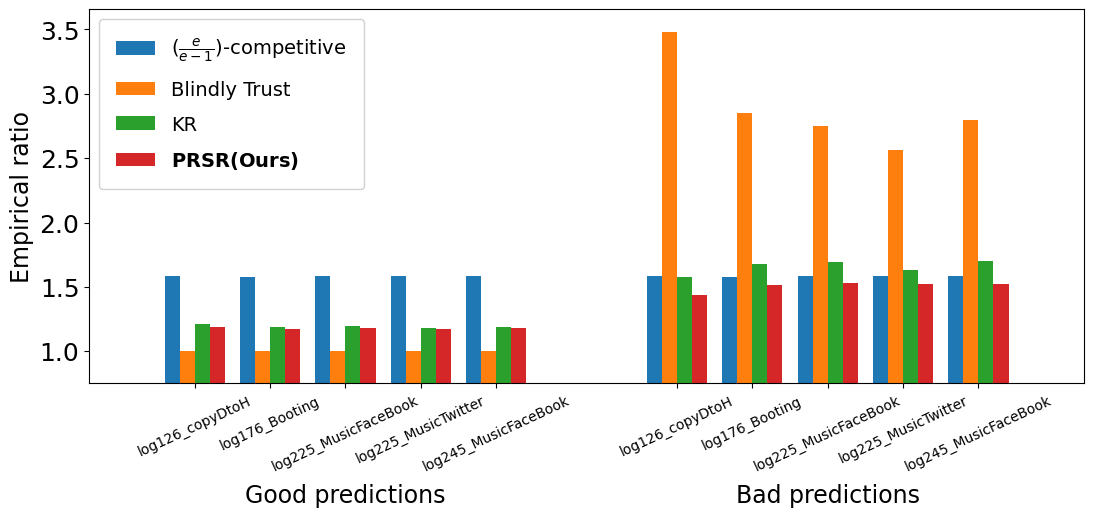

In [1070]:
import matplotlib.pyplot as plt
import numpy as np
import os

labels = df[("", "File")].tolist()
competitive = df[("", "Competitive")].to_numpy()
good_data = df["Good predictions"].to_numpy()
bad_data = df["Bad predictions"].to_numpy()

bar_width = 0.2
gap = 1.4   
x = np.arange(len(labels))
x_bad = x + len(labels) + gap

colors = {
    "Competitive": "#1f77b4",
    "FTP": "#ff7f0e",
    "KD": "#2ca02c",
    "PDSR": "#d62728"
}

fig, ax = plt.subplots(figsize=(10.8, 5))

ax.bar(x - 1.5 * bar_width, competitive, width=bar_width, label=r"$(\frac{e}{e-1})$-competitive", color=colors["Competitive"])
ax.bar(x - 0.5 * bar_width, good_data[:, 0], width=bar_width, label="Blindly Trust", color=colors["FTP"])
ax.bar(x + 0.5 * bar_width, good_data[:, 1], width=bar_width, label="KR", color=colors["KD"])
ax.bar(x + 1.5 * bar_width, good_data[:, 2], width=bar_width, label=r"$\mathbf{PRSR(Ours)}$", color=colors["PDSR"])

ax.bar(x_bad - 1.5 * bar_width, competitive, width=bar_width, color=colors["Competitive"])
ax.bar(x_bad - 0.5 * bar_width, bad_data[:, 0], width=bar_width, color=colors["FTP"])
ax.bar(x_bad + 0.5 * bar_width, bad_data[:, 1], width=bar_width, color=colors["KD"])
ax.bar(x_bad + 1.5 * bar_width, bad_data[:, 2], width=bar_width, color=colors["PDSR"])

ax.set_ylim(0.75, None)
ax.set_ylabel("Empirical ratio", fontsize=17)
plt.tick_params(axis='y', labelsize=18) 

xticks = np.concatenate([x, x_bad])
xticklabels = labels + labels
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=25, ha="center", fontsize=10)

ymin, ymax = ax.get_ylim()
mid_good = (x[0] + x[-1]) / 2
mid_bad = (x_bad[0] + x_bad[-1]) / 2

offset_main_label = 0.18 * (ymax - ymin)
offset_brace = 0.10 * (ymax - ymin)

ax.text(mid_good, ymin - offset_main_label - 0.25, "Good predictions",
        ha="center", va="top", fontsize=17)
ax.text(mid_bad, ymin - offset_main_label - 0.25, "Bad predictions",
        ha="center", va="top", fontsize=17)

brace_y = ymin - offset_brace
ax.plot([x[0] - 0.8, x[-1] + 0.8], [brace_y, brace_y], color="black", lw=1.2)
ax.plot([x_bad[0] - 0.8, x_bad[-1] + 0.8], [brace_y, brace_y], color="black", lw=1.2)

ax.legend(
    loc="upper left",
    fontsize=14,           
    frameon=True,
    fancybox=True,
    framealpha=0.9,
    borderpad=0.9,
    labelspacing=0.8,      
    handletextpad=0.8,     
    columnspacing=1.2
)

plt.subplots_adjust(bottom=0.42, left=0.08, right=0.98, top=0.96)
plt.tight_layout()

desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
plt.savefig(os.path.join(desktop_path, "DMP.pdf"), bbox_inches="tight")
plt.show()